In [1]:
# Import necessary libraries
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torchvision import transforms
from scipy.io import wavfile

In [2]:
# Mount Google Drive if necessary
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

directory = "/content/drive/MyDrive/cs545/FinalProject/"

Mounted at /content/drive


In [3]:
# Define the autoregressive model
class AudioRestorationModel(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, dilation):
        super(AudioRestorationModel, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, hidden_channels, kernel_size=kernel_size, dilation=dilation)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(hidden_channels, input_channels, kernel_size=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        return x

In [4]:

# Function to load spectrogram data from a given path
def load_spectrogram_data(folder_path):
    # Load your spectrogram data, adjust accordingly based on your data format
    # For example, you may use librosa library to load audio files and compute spectrograms
    # spectrogram_data = ...

    # Assume you have a 3D numpy array where the last dimension represents different channels (e.g., time, frequency, amplitude)

    spectrogram_data = []

    # Loop through all files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            file_path = os.path.join(folder_path, filename)

            # Read the PNG file and convert it to a numpy array
            image = Image.open(file_path)
            spectrogram = np.array(image)

            # Assuming your spectrogram is a 2D array, you might need to adapt this based on your actual data
            spectrogram_data.append(spectrogram)

    # Convert the list of spectrograms to a numpy array
    spectrogram_data = np.array(spectrogram_data)

    return spectrogram_data

# Function to create a dataset with missing values
def create_dataset_with_missing_values(spectrogram_data, missing_ratio=0.1):
    # Create a mask for missing values
    mask = np.random.rand(*spectrogram_data.shape) > missing_ratio

    # Apply the mask to create a dataset with missing values
    distorted_data = spectrogram_data.copy()
    distorted_data[mask] = 0.0  # You can choose a different value for missing values

    return distorted_data, mask

# Function to convert spectrogram to wav audio
def spectrogram_to_audio(spectrogram):
    # You need to implement this function based on your specific requirements
    # For example, you can use the inverse transformation from the one used to create the spectrogram

    # For now, let's assume a simple implementation for demonstration purposes
    sample_rate = 44100  # Adjust based on your audio data
    _, audio_data = wavfile.read('your_audio_file.wav')  # Load your original audio file
    return audio_data

# Function to plot spectrogram
def plot_spectrogram(spectrogram, title):
    plt.imshow(spectrogram.T, aspect='auto', origin='lower', cmap='viridis')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

# Function to train the autoregressive model
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

# Function to evaluate the model
def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(test_loader)


In [5]:
# Main code
data_path = directory+'/Data/images_original/pop/'

# Step 1: Load the spectrogram data
spectrogram_data = load_spectrogram_data(data_path)


In [6]:
print(spectrogram_data.shape)

(100, 288, 432, 4)


In [7]:
# Step 2: Create a dataset with missing values
distorted_data, mask = create_dataset_with_missing_values(spectrogram_data)
print(distorted_data.shape)
print(mask.shape)

(100, 288, 432, 4)
(100, 288, 432, 4)


In [8]:

# Step 3: Split the dataset into training and testing sets
train_data, test_data, train_mask, test_mask = train_test_split(distorted_data, mask, test_size=0.2, random_state=42)
print(train_data.shape, test_data.shape)
print(train_mask.shape, test_mask.shape)

(80, 288, 432, 4) (20, 288, 432, 4)
(80, 288, 432, 4) (20, 288, 432, 4)


In [19]:
spectrogram_data.shape

(100, 288, 432, 4)

In [21]:
# train_data, test_data, train_mask, test_mask = train_data[:,:,:,0], test_data[:,:,:,0], train_mask[:,:,:,0], test_mask[:,:,:,0]
# print(train_data.shape, test_data.shape)
# print(train_mask.shape, test_mask.shape)
# Step 4: Preprocess the spectrogram data if required (you may need to define specific transformations)
# For example, you can use torch.transforms to apply normalization or other preprocessing steps
from torchvision.transforms.functional import to_pil_image, to_tensor

# Step 4: Preprocess the spectrogram data if required (you may need to define specific transformations)
# For example, you can use torch.transforms to apply normalization or other preprocessing steps
transform = transforms.Compose([transforms.ToPILImage(),  # Convert to PIL Image
                                transforms.ToTensor()])  # ToTensor handles normalization

# Apply the transform to the data
train_data_tensor = torch.stack([transform(img) for img in train_data])  # Assuming train_data is a list of 4-channel images
test_data_tensor = torch.stack([transform(img) for img in test_data])    # Assuming test_data is a list of 4-channel images

# Assuming your spectrogram_data is a list of 4-channel images
train_target_tensor = torch.stack([transform(img) for img in train_data[train_mask]])
test_target_tensor = torch.stack([transform(img) for img in test_data[test_mask]])

# Create TensorDatasets using the transformed data
train_dataset = TensorDataset(train_data_tensor, train_target_tensor)
test_dataset = TensorDataset(test_data_tensor, test_target_tensor)


TypeError: ignored

In [ ]:

# Step 5: Initialize the autoregressive model
input_channels = 1  # Assuming mono audio
hidden_channels = 64
kernel_size = 3
dilation = 2

model = AudioRestorationModel(input_channels, hidden_channels, kernel_size, dilation)


In [ ]:

# Step 6: Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:

# Step 7: Train the model
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
num_epochs = 10  # Adjust based on your requirements

train_model(model, train_loader, criterion, optimizer, num_epochs)


In [ ]:

# Step 8: Evaluate the model
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_loss = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss}')


In [ ]:


# Step 9: Plot error graph or any other insights for model performance
# For example, you can plot the spectrogram of the predicted vs actual values

# Plot original spectrogram
plot_spectrogram(spectrogram_data, 'Original Spectrogram')

# Plot distorted spectrogram
plot_spectrogram(distorted_data, 'Distorted Spectrogram')

# Predict the missing values
model.eval()
with torch.no_grad():
    predicted_data = model(torch.Tensor(test_data)).numpy()

# Plot predicted spectrogram
plot_spectrogram(predicted_data, 'Predicted Spectrogram')


In [ ]:

# Step 10: Display and listen to the spectrogram with missing values and predicted values
# For demonstration purposes, you can use the simple implementation provided earlier
# You may need to implement a proper function based on your specific requirements
audio_original = spectrogram_to_audio(spectrogram_data)
audio_distorted = spectrogram_to_audio(distorted_data)
audio_predicted = spectrogram_to_audio(predicted_data)

# Listen to the audio
from IPython.display import Audio

print('Original Audio:')
Audio(audio_original, rate=sample_rate)

print('Distorted Audio:')
Audio(audio_distorted, rate=sample_rate)

print('Predicted Audio:')
Audio(audio_predicted, rate=sample_rate)


In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from scipy.io import wavfile
from scipy.signal import spectrogram
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

# Function to load and preprocess the audio file
def load_and_preprocess_audio(file_path, duration=10, sample_rate=44100):
    # Load the audio file
    _, audio_data = wavfile.read(file_path)

    # Trim or pad the audio to a fixed duration
    target_length = duration * sample_rate
    if len(audio_data) < target_length:
        audio_data = np.pad(audio_data, (0, target_length - len(audio_data)))
    elif len(audio_data) > target_length:
        audio_data = audio_data[:target_length]

    # Compute the spectrogram
    _, _, spectrogram_data = spectrogram(audio_data, fs=sample_rate, nperseg=1024, noverlap=512, nfft=2048)

    return audio_data, spectrogram_data

# Function to create a dataset with missing values
# def create_dataset_with_missing_values(spectrogram_data, missing_ratio=0.1):
#     # Create a mask for missing values
#     mask = np.tri(spectrogram_data.shape[0], spectrogram_data.shape[1], -1, dtype=bool)
#     mask[:, :int(spectrogram_data.shape[1] * missing_ratio)] = False

#     # Apply the mask to create a dataset with missing values
#     distorted_data = spectrogram_data.copy()
#     distorted_data[mask] = 0.0

#     return distorted_data, mask

def create_dataset_with_missing_values(spectrogram_data, missing_ratio=0.1):
    # Create a mask for missing values
    mask = np.tri(spectrogram_data.shape[0], spectrogram_data.shape[1], -1, dtype=bool)
    mask[:, :int(spectrogram_data.shape[1] * missing_ratio)] = False

    # Transpose the mask to match dimensions
    # mask = mask.T

    # Apply the mask to create a dataset with missing values
    distorted_data = spectrogram_data.copy()
    distorted_data[mask] = 0.0

    print("shape of distorted_data: ", distorted_data.shape)
    print("shape of mask: ", mask.shape)

    return distorted_data, mask


from scipy.signal import istft
from scipy.io.wavfile import write
# Function to convert spectrogram to audio
def spectrogram_to_audio(spectrogram, file_path, sample_rate=44100):
    _, audio_data = istft(spectrogram, fs=sample_rate, nperseg=1024, noverlap=512, nfft=2048)
    write(file_path, sample_rate, audio_data)
    return
    # return audio_data

# Define the autoregressive model
class AudioRestorationModel(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, dilation):
        super(AudioRestorationModel, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, hidden_channels, kernel_size=kernel_size, dilation=dilation)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(hidden_channels, input_channels, kernel_size=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        return x

# Function to train the autoregressive model
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    train_losses = []

    for epoch in range(num_epochs):
        for inputs, targets in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

    return train_losses

# Function to evaluate the model
def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

    return total_loss / len(test_loader)

# Main code
directory = "/content/drive/MyDrive/cs545/FinalProject/"
file_path = directory + 'Data/genres_original/pop/pop.00000.wav'  # Adjust the path to your audio file
audio_data, spectrogram_data = load_and_preprocess_audio(file_path)

# Create a dataset with missing values
distorted_data, mask = create_dataset_with_missing_values(spectrogram_data)

# Split the dataset into training and testing sets
train_data, test_data, train_mask, test_mask = train_test_split(distorted_data, mask, test_size=0.2, random_state=42)

# Initialize the autoregressive model
input_channels = spectrogram_data.shape[0]
hidden_channels = 64
kernel_size = 3
dilation = 2

model = AudioRestorationModel(input_channels, hidden_channels, kernel_size, dilation)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("spectrogram_data shape: ", spectrogram_data.shape)
print("train_data shape: ", train_data.shape)
print("test_data shape: ", test_data.shape)

# Create TensorDatasets
train_dataset = TensorDataset(torch.Tensor(train_data), torch.Tensor(spectrogram_data[train_mask]))
test_dataset = TensorDataset(torch.Tensor(test_data), torch.Tensor(spectrogram_data[test_mask]))

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Train the model
num_epochs = 10
train_losses = train_model(model, train_loader)


# Evaluate the model
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_loss = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss}')

# Plot error graph
plt.plot(train_losses)
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Predict the missing values
model.eval()
with torch.no_grad():
    predicted_data = model(torch.Tensor(test_data)).numpy()

# Plot original spectrogram
plt.imshow(spectrogram_data, aspect='auto', origin='lower', cmap='viridis')
plt.title('Original Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar(format='%+2.0f dB')
plt.show()

# Plot distorted spectrogram
plt.imshow(distorted_data, aspect='auto', origin='lower', cmap='viridis')
plt.title('Distorted Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar(format='%+2.0f dB')
plt.show()

# Plot predicted spectrogram
plt.imshow(predicted_data, aspect='auto', origin='lower', cmap='viridis')
plt.title('Predicted Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar(format='%+2.0f dB')
plt.show()

output_filepath = directory + 'Data/genres_original/pop/pop.00000.processed.wav'
# Convert the predicted spectrogram to audio
predicted_audio = spectrogram_to_audio(predicted_data, output_filepath)

# Listen to the audio
from IPython.display import Audio

print('Original Audio:')
Audio(audio_data, rate=44100)

print('Predicted Audio:')
Audio(predicted_audio, rate=44100)

shape of distorted_data:  (1025, 860)
shape of mask:  (1025, 860)
spectrogram_data shape:  (1025, 860)
train_data shape:  (820, 860)
test_data shape:  (205, 860)


IndexError: ignored

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LSTM, Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Assuming you have the following data (replace with your actual data)
# spectrogram_audio: Original spectrogram
# distorted_audio: Spectrogram with missing values

# Assuming both spectrogram_audio and distorted_audio are numpy arrays
# with shape (num_samples, num_frequencies, num_time_steps)\

num_frequencies =1025
num_time_steps = 860

# Define the model
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(1, num_frequencies, num_time_steps)))
model.add(LSTM(units=64, return_sequences=True))
model.add(Flatten())
model.add(Dense(units=num_frequencies * num_time_steps))  # Adjust this based on your desired output shape

model.compile(optimizer=Adam(), loss='mean_squared_error')

# # Model training
# model.fit(distorted_data, spectrogram_data, epochs=10, batch_size=8, validation_split=0.2)

# # Model prediction
# restored_spectrogram = model.predict(distorted_data)
# restored_spectrogram = restored_spectrogram.reshape(-1, num_frequencies, num_time_steps)


# # Assuming you want to visualize the results
# sample_index = 0  # Choose a sample for visualization
# plt.figure(figsize=(12, 6))

# # Original Spectrogram
# plt.subplot(1, 3, 1)
# plt.imshow(np.log1p(spectrogram_data[sample_index, :, :]), aspect='auto', origin='lower')
# plt.title('Original Spectrogram')

# # Distorted Spectrogram
# plt.subplot(1, 3, 2)
# plt.imshow(np.log1p(distorted_data[sample_index, :, :]), aspect='auto', origin='lower')
# plt.title('Distorted Spectrogram')

# # Restored Spectrogram
# plt.subplot(1, 3, 3)
# plt.imshow(np.log1p(restored_spectrogram[sample_index, :, :]), aspect='auto', origin='lower')
# plt.title('Restored Spectrogram')

# plt.show()

ValueError: ignored

In [1]:
# Mount Google Drive if necessary
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

directory = "/content/drive/MyDrive/cs545/FinalProject/"

Mounted at /content/drive


In [2]:
import numpy as np
import librosa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Reshape
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Step 1: Load the raw audio file
file_path = 'path/to/your/audio/file.wav'
file_path = directory + 'Data/genres_original/pop/pop.00000.wav'

audio, sr = librosa.load(file_path, sr=None)

# Step 2: Create a spectrogram from the raw audio
def create_spectrogram(audio, n_fft=1024, hop_length=256):
    spectrogram = librosa.feature.melspectrogram(y = audio, sr=sr, n_fft=n_fft, hop_length=hop_length)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    return spectrogram_db

spectrogram = create_spectrogram(audio)

# Step 3: Introduce distortion or missing values
# For simplicity, let's remove a portion of the spectrogram
distorted_spectrogram = spectrogram.copy()
distorted_spectrogram[:, :100] = 0  # Remove the first 100 columns
print("distorted_spectrogram shape : ", distorted_spectrogram.shape)
# Step 4: Prepare data for training
num_frequencies, num_time_steps = distorted_spectrogram.shape

'''
X_train = np.expand_dims(distorted_spectrogram, axis=-1)  # Add channel dimension
y_train = np.expand_dims(spectrogram, axis=-1)


num_samples = 1

# Step 5: Build and train the model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=( num_samples,num_frequencies, num_time_steps)))
# Assuming num_frequencies = 128, num_time_steps = 2585
# model.add(Reshape((num_frequencies, num_time_steps), input_shape=(num_frequencies, num_time_steps)))
# model.add(Reshape((num_time_steps, num_frequencies * 1), input_shape=(num_frequencies, num_time_steps, 1)))
# model.add(LSTM(units=64, return_sequences=True))
model.add(Dense(units=num_frequencies))
model.compile(optimizer=Adam(), loss='mean_squared_error')
model.fit(X_train, y_train, epochs=1, batch_size=1)

# Step 6: Model prediction
restored_spectrogram = model.predict(X_train)

# Step 7: Visualize the results
plt.figure(figsize=(12, 6))

# Original Spectrogram
plt.subplot(1, 3, 1)
plt.imshow(spectrogram, aspect='auto', origin='lower')
plt.title('Original Spectrogram')

# Distorted Spectrogram
plt.subplot(1, 3, 2)
plt.imshow(distorted_spectrogram, aspect='auto', origin='lower')
plt.title('Distorted Spectrogram')

# Restored Spectrogram
plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(restored_spectrogram), aspect='auto', origin='lower')
plt.title('Restored Spectrogram')

plt.show()
'''

distorted_spectrogram shape :  (128, 2585)


"\nX_train = np.expand_dims(distorted_spectrogram, axis=-1)  # Add channel dimension\ny_train = np.expand_dims(spectrogram, axis=-1)\n\n\nnum_samples = 1\n\n# Step 5: Build and train the model\nmodel = Sequential()\nmodel.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=( num_samples,num_frequencies, num_time_steps)))\n# Assuming num_frequencies = 128, num_time_steps = 2585\n# model.add(Reshape((num_frequencies, num_time_steps), input_shape=(num_frequencies, num_time_steps)))\n# model.add(Reshape((num_time_steps, num_frequencies * 1), input_shape=(num_frequencies, num_time_steps, 1)))\n# model.add(LSTM(units=64, return_sequences=True))\nmodel.add(Dense(units=num_frequencies))\nmodel.compile(optimizer=Adam(), loss='mean_squared_error')\nmodel.fit(X_train, y_train, epochs=1, batch_size=1)\n\n# Step 6: Model prediction\nrestored_spectrogram = model.predict(X_train)\n\n# Step 7: Visualize the results\nplt.figure(figsize=(12, 6))\n\n# Original Spectrogram\nplt.subplot(1,

In [ ]:

# Flatten the data
num_samples = 1
num_frequencies, num_time_steps = spectrogram.shape

spectrogram = spectrogram[:8,:]
distorted_spectrogram = distorted_spectrogram[:8,]
num_frequencies, num_time_steps = spectrogram.shape

print(num_frequencies, num_time_steps)
spectrogram_flat = spectrogram.reshape((num_samples, num_frequencies * num_time_steps))
distorted_spectrogram_flat = distorted_spectrogram.reshape((num_samples, num_frequencies * num_time_steps))


print(num_frequencies, num_time_steps)
print("distorted_spectrogram_flat shape: ", distorted_spectrogram_flat.shape)
print("spectrogram_flat.shape shape: ", spectrogram_flat.shape)

# Define the model
model = Sequential()
model.add(Dense(units=num_frequencies * num_time_steps, input_shape=(num_frequencies * num_time_steps,)))
model.add(Dense(units=num_frequencies * num_time_steps))  # Adjust this based on your desired output shape

model.compile(optimizer=Adam(), loss='mean_squared_error')

# Model training
model.fit(distorted_spectrogram_flat, spectrogram_flat, epochs=1, batch_size=1, validation_split=0.0)

# Model prediction
restored_spectrogram_flat = model.predict(distorted_spectrogram_flat)

# Reshape the restored spectrogram back to 2D
restored_spectrogram = restored_spectrogram_flat.reshape((num_samples, num_frequencies, num_time_steps))

# Assuming you want to visualize the results
sample_index = 0  # Choose a sample for visualization
plt.figure(figsize=(10, 6))

# Original Spectrogram
plt.subplot(1, 3, 1)
plt.imshow(np.log1p(spectrogram[sample_index, :, :]), aspect='auto', origin='lower')
plt.title('Original Spectrogram')

# Distorted Spectrogram
plt.subplot(1, 3, 2)
plt.imshow(np.log1p(distorted_spectrogram[sample_index, :, :]), aspect='auto', origin='lower')
plt.title('Distorted Spectrogram')

# Restored Spectrogram
plt.subplot(1, 3, 3)
plt.imshow(np.log1p(restored_spectrogram[sample_index, :, :]), aspect='auto', origin='lower')
plt.title('Restored Spectrogram')

plt.show()

8 2585
8 2585
distorted_spectrogram_flat shape:  (1, 20680)
spectrogram_flat.shape shape:  (1, 20680)


In [4]:

import numpy as np

from matplotlib.pylab import *
from scipy.io import wavfile
from scipy.signal import stft
from IPython.display import Audio

import matplotlib.pyplot as plt
from scipy.sparse import linalg
import scipy
from numpy import *

file_path = directory + 'Data/genres_original/pop/pop.00000.wav'

audio, sr = librosa.load(file_path, sr=None)

22050


(Text(0.5, 0, 'Time (sec)'), Text(0, 0.5, 'Amplitude'))

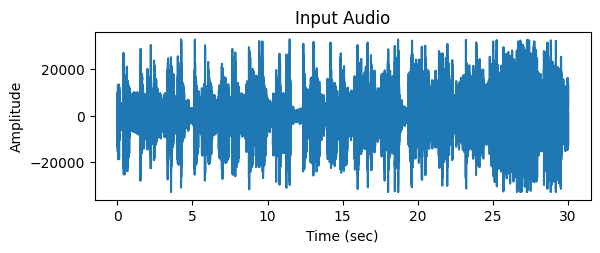

In [6]:
sample_rate , data = wavfile.read(file_path)
print(sample_rate)
# Plotting audio
subplot(2, 1, 1), plot(arange(0, len(data))/sample_rate, data)
title('Input Audio')
xlabel('Time (sec)'), ylabel('Amplitude')

(10923,)
(47,)
(10923, 47)


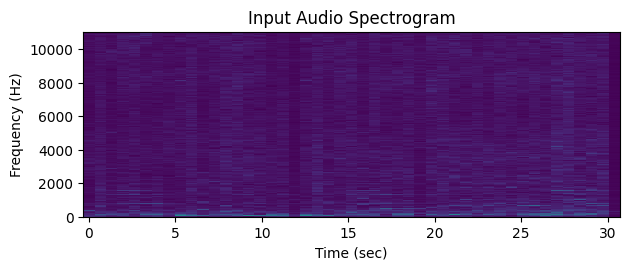

In [23]:
# Plotting magnitude of the spectrogram
window_size = 21844
overlap = 1/3 * window_size
sample_frequencies, segment_times , Z = stft(data, window='hann', fs = sample_rate, nperseg = window_size, noverlap = overlap)
Z = abs(Z)
print(sample_frequencies.shape)
print(segment_times.shape)
print(Z.shape)
subplot(2, 1, 2), pcolormesh(segment_times, sample_frequencies, np.sqrt(Z)), title('Input Audio Spectrogram')
xlabel('Time (sec)'), ylabel('Frequency (Hz)')
tight_layout()